In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import re
import gc
import sys
import time
import warnings
import json
import torch
import emoji
import random
import unicodedata
import multiprocessing
import seaborn as sns
from functools import partial, lru_cache
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')
sub = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv')

# Understanding Data

In [2]:
train_len, test_len = len(train.index), len(test.index)
print("Train Size:", train_len)
print("Test Size:", test_len)
print("Train shape: ", train.shape)

Train Size: 1804874
Test Size: 97320
Train shape:  (1804874, 45)


In [3]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [4]:
test.head() 

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


### Missing Values

In [5]:
miss_val = train.isnull().sum(axis=0) / train_len
miss_val = miss_val[miss_val > 0] * 100
miss_val

asian                                  77.553558
atheist                                77.553558
bisexual                               77.553558
black                                  77.553558
buddhist                               77.553558
christian                              77.553558
female                                 77.553558
heterosexual                           77.553558
hindu                                  77.553558
homosexual_gay_or_lesbian              77.553558
intellectual_or_learning_disability    77.553558
jewish                                 77.553558
latino                                 77.553558
male                                   77.553558
muslim                                 77.553558
other_disability                       77.553558
other_gender                           77.553558
other_race_or_ethnicity                77.553558
other_religion                         77.553558
other_sexual_orientation               77.553558
physical_disability 

### Target Plots

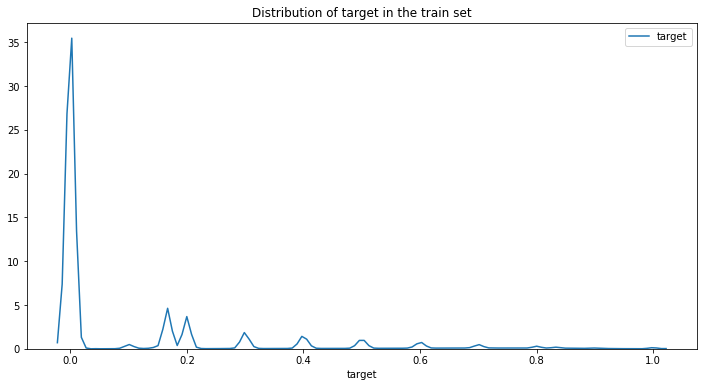

In [6]:
plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(train['target'],kde=True,hist=False, bins=20, label='target')
plt.legend()
plt.show()

In [7]:
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']
races = ['black','white','asian','latino','other_race_or_ethnicity']
religions = ['atheist', 'buddhist', 'christian', 'hindu', 'muslim', 'jewish','other_religion']
sexual_orientation = ['heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation']

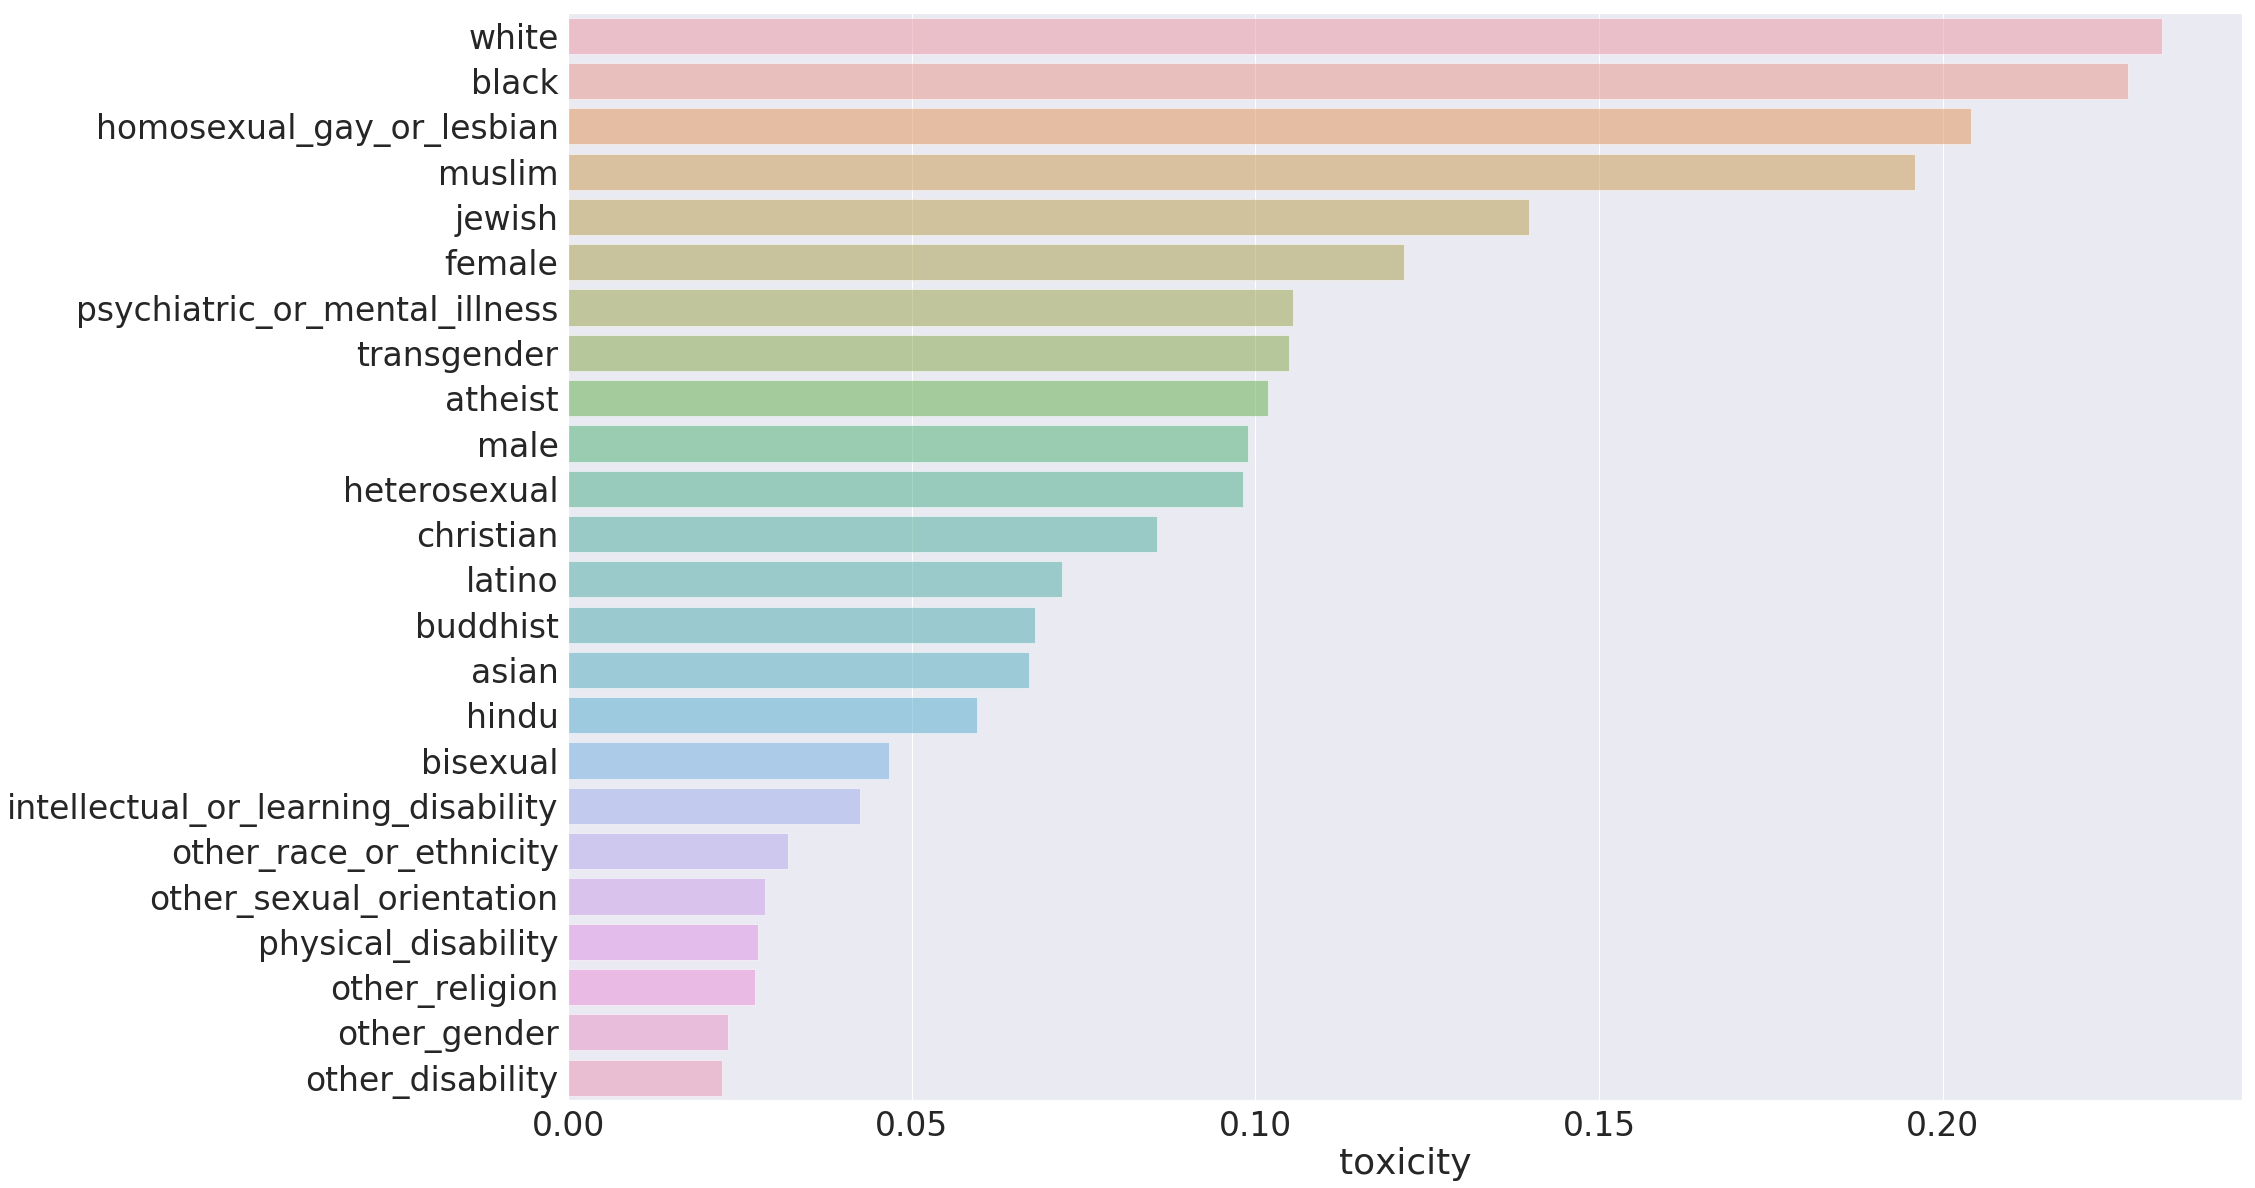

In [8]:
targets = train.loc[:, ['target']+list(train)[slice(8,32)]].dropna()
toxicity = targets.iloc[:, 1:].multiply(targets.iloc[:, 0],
                                        axis="index").sum()/targets.iloc[:, 1:][targets.iloc[:, 1:]>0].count()
toxicity = toxicity.sort_values(ascending=False)
plt.figure(figsize=(30,20))
sns.set(font_scale=3)
ax = sns.barplot(x = toxicity.values, y = toxicity.index, alpha=0.5)
plt.xlabel('toxicity')
plt.show()

### Time Series (based on feature `created_date`)

In [9]:
date = train.loc[:, ['created_date', 'target'] + identities].dropna()
weighted = date.iloc[:, 2:] / date.iloc[:, 2:].sum()
target_weighted = weighted.multiply(date.iloc[:, 1], axis="index")

In [10]:
target_weighted['created_date'] = pd.to_datetime(date['created_date'].apply(lambda dt: dt[:10]))
identity_weight_per_date = target_weighted.groupby(['created_date']).sum().sort_index()

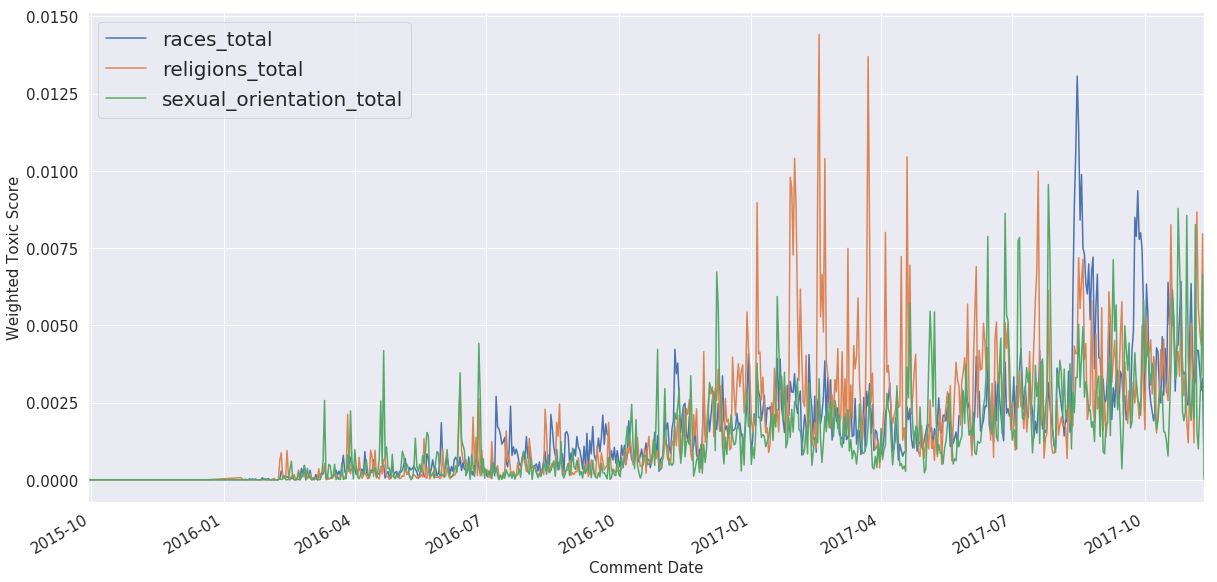

In [11]:
identity_weight_per_date['races_total'] = identity_weight_per_date[races].sum(axis=1)
identity_weight_per_date['religions_total'] = identity_weight_per_date[religions].sum(axis=1)
identity_weight_per_date['sexual_orientation_total'] = identity_weight_per_date[sexual_orientation].sum(axis=1)
identity_weight_per_date[['races_total', 'religions_total', 'sexual_orientation_total']].plot(figsize=(20,10),
                                                                                             fontsize=15)
plt.xlabel('Comment Date', fontsize=15)
plt.ylabel('Weighted Toxic Score', fontsize=15)
plt.legend(loc=2, prop={'size': 20})

### Correlations

In [12]:
comments_with_date = train.loc[:, ['created_date', 'target','comment_text'] + identities].dropna()
comments_with_date['created_date'] = pd.to_datetime(date['created_date'].apply(lambda dt: dt[:10]))
comments_with_date['comment_count'] = 1

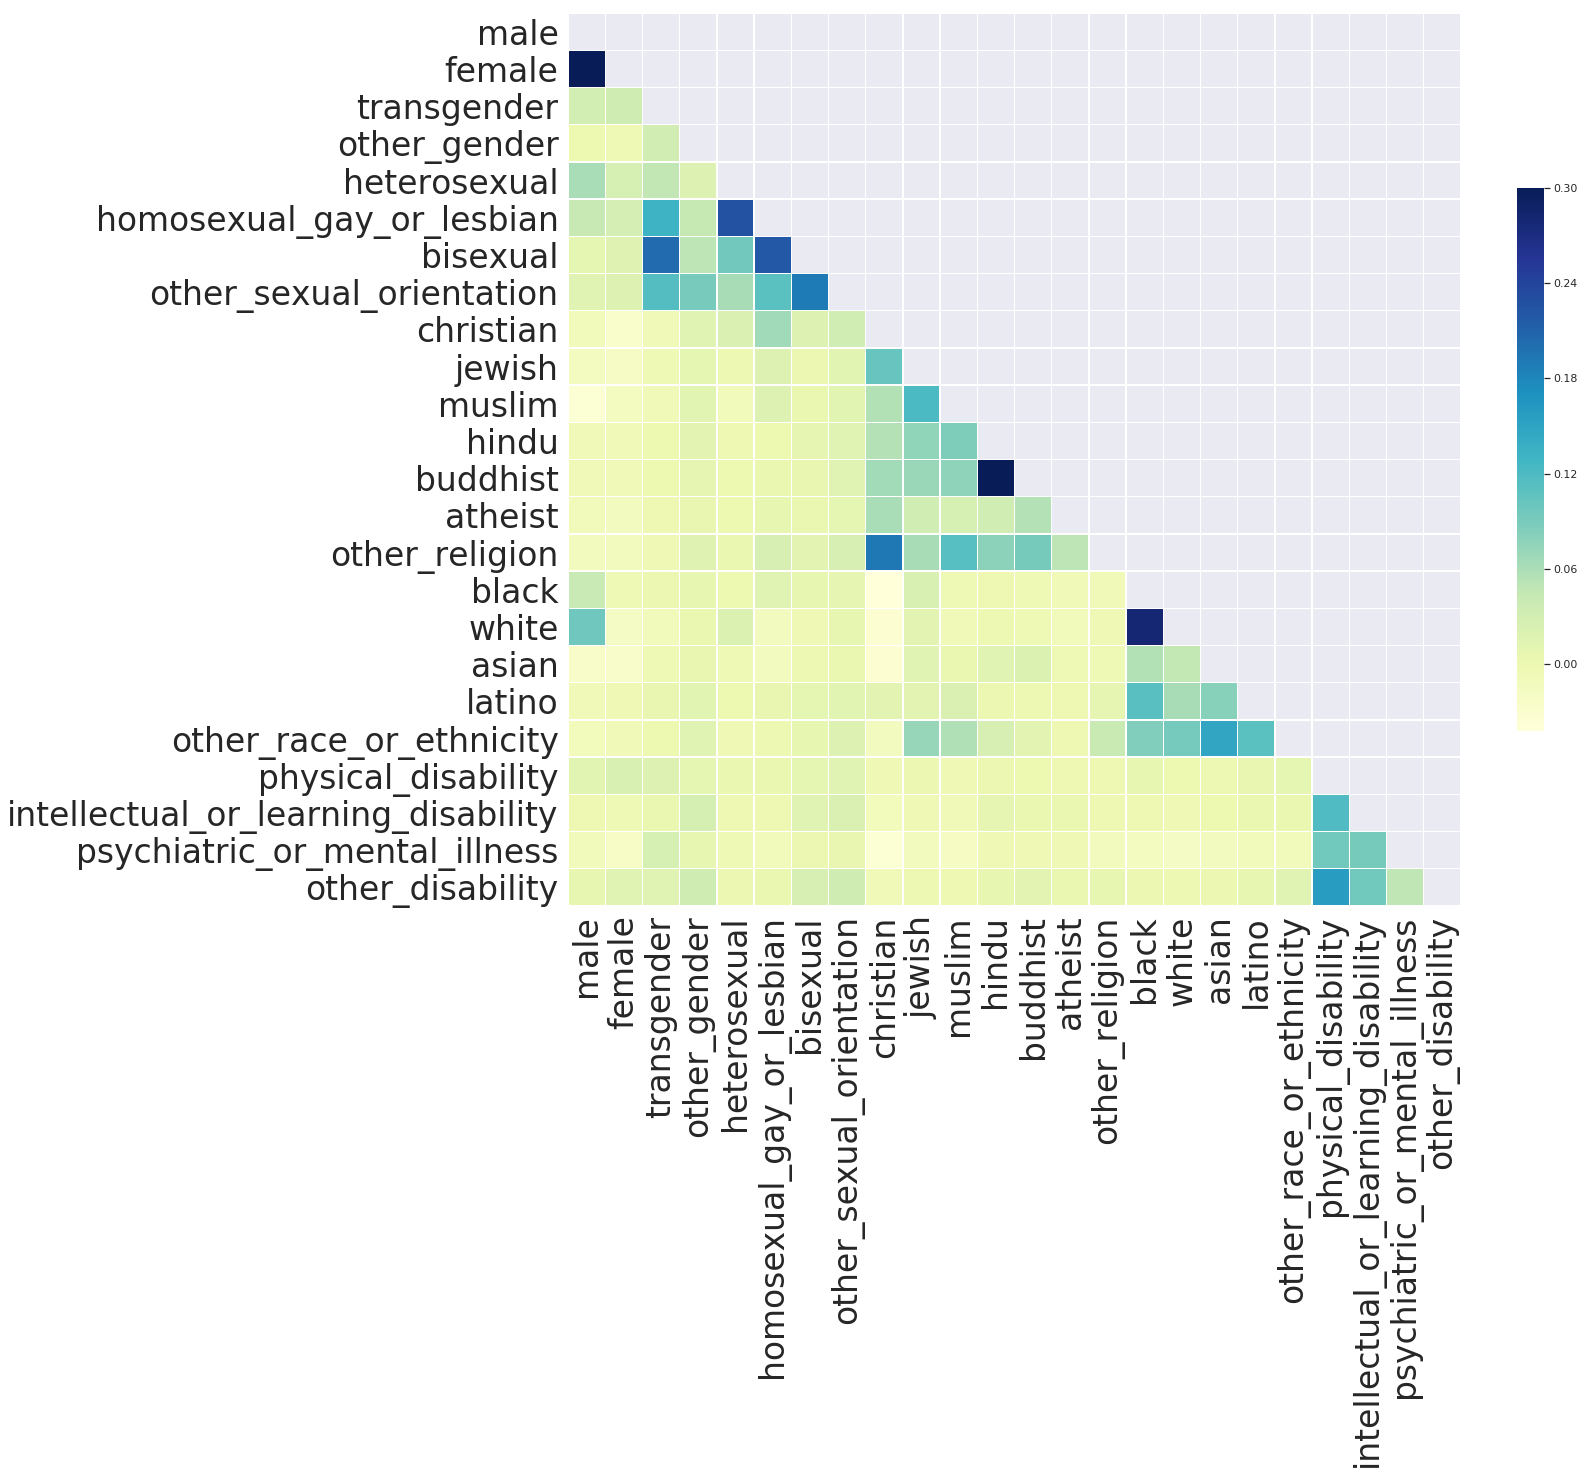

In [13]:
corr = comments_with_date[identities].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale = 1)
sns.heatmap(corr,mask=mask,square=True,annot=False,cmap="YlGnBu",vmax=0.3,
           linewidths=.5, cbar_kws={"shrink": .5})

### Word Clouds

In [14]:
stopwords = set(STOPWORDS)
def generate_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=100,
        max_font_size=40, 
        scale=5,
        random_state=23
    ).generate(str(data))

    fig = plt.figure(1, figsize=(20,20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

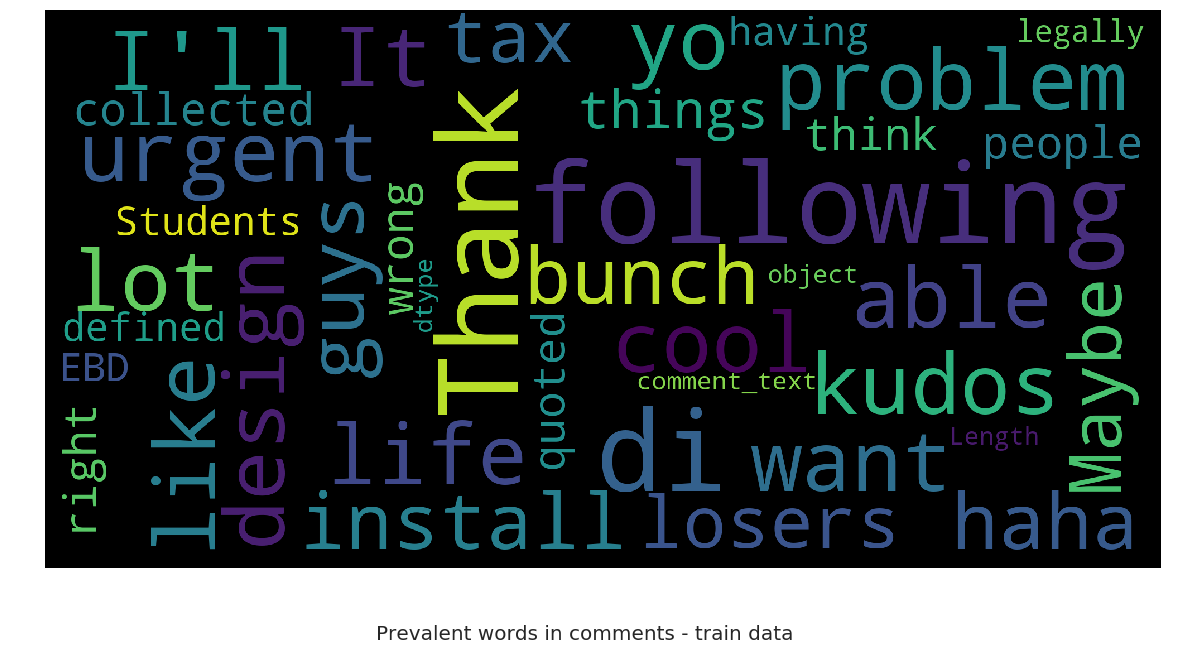

In [15]:
generate_wordcloud(train['comment_text'], title = 'Prevalent words in comments - train data')

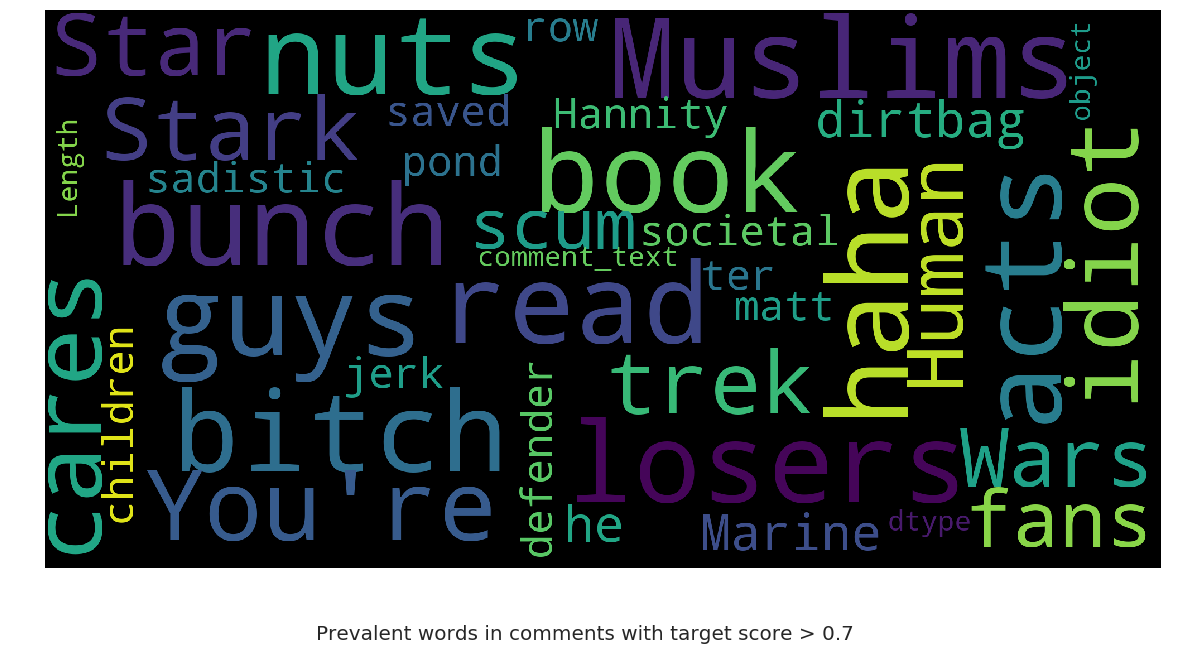

In [16]:
generate_wordcloud(train.loc[train['target'] > 0.7]['comment_text'], 
               title = 'Prevalent words in comments with target score > 0.7')

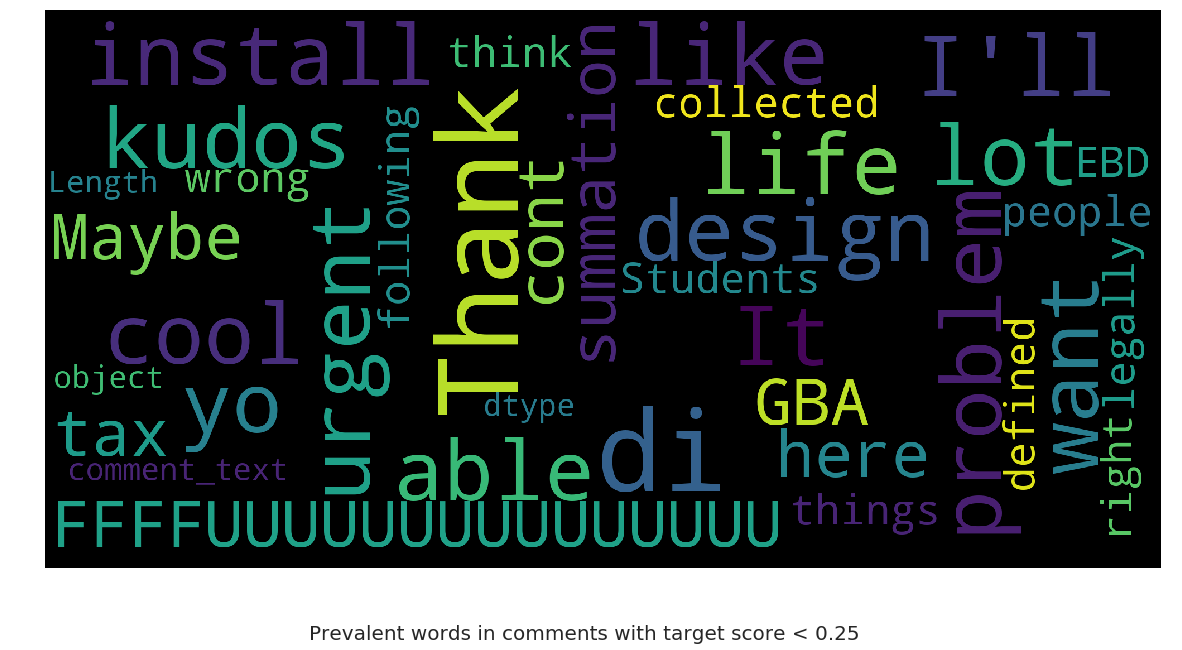

In [17]:
generate_wordcloud(train.loc[train['target'] < 0.25]['comment_text'], 
               title = 'Prevalent words in comments with target score < 0.25')

### Emoji Analysis

In [18]:
def extract_emojis(str):
    return [c for c in str if c in emoji.UNICODE_EMOJI]

In [19]:
comments_with_date['emoji_count'] = comments_with_date['comment_text'].apply(lambda x: len(extract_emojis(x)))

In [20]:
emoji_mean_per_identity = []

for identity in identities:
    toxic_emoji_mean = comments_with_date[(comments_with_date[identity]> 0) & (comments_with_date['target']
                                                                               >= .5)]['emoji_count'].mean()
    non_toxic_emoji_mean = comments_with_date[(comments_with_date[identity]> 0) & (comments_with_date['target']
                                                                                   < .5)]['emoji_count'].mean()
    emoji_mean_per_identity.append([identity, toxic_emoji_mean, non_toxic_emoji_mean])

emoji_mean_per_identity = pd.DataFrame(emoji_mean_per_identity, columns = ['identity','toxic',
                                                                           'non toxic']).set_index('identity')

Text(0.5, 1.0, 'Emojis usage in comments for different identities')

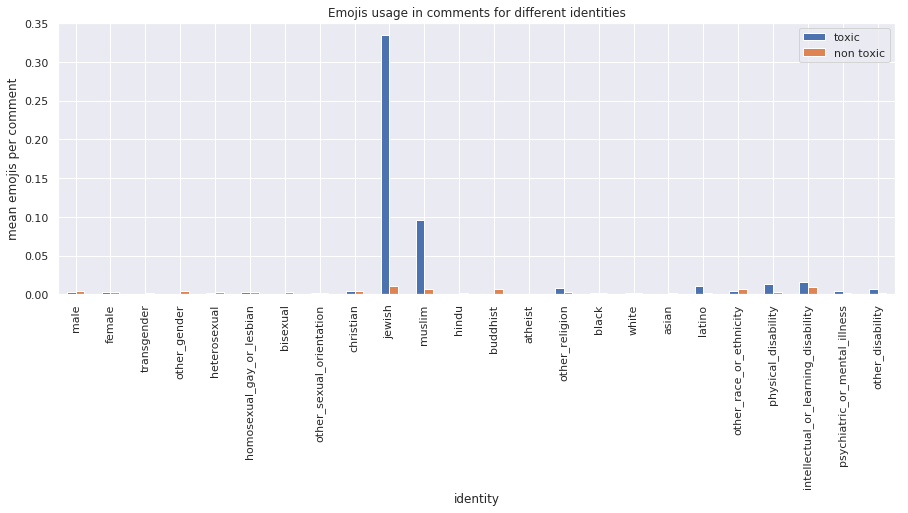

In [21]:
emoji_mean_per_identity.plot.bar(figsize=(15,5))
plt.ylabel('mean emojis per comment')
plt.title('Emojis usage in comments for different identities')

# Feature Generation

In [22]:
train['total_length'] = train['comment_text'].apply(len)
train['number_exclamation_marks'] = train['comment_text'].apply(lambda comment: comment.count('!'))
train['number_question_marks'] = train['comment_text'].apply(lambda comment: comment.count('?'))
train['number_punctuation'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train['number_symbols'] = train['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
train['number_words'] = train['comment_text'].apply(lambda comment: len(comment.split()))
train['number_unique_words'] = train['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))

test['total_length'] = test['comment_text'].apply(len)
test['number_exclamation_marks'] = test['comment_text'].apply(lambda comment: comment.count('!'))
test['number_question_marks'] = test['comment_text'].apply(lambda comment: comment.count('?'))
test['number_punctuation'] = test['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
test['number_symbols'] = test['comment_text'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
test['number_words'] = test['comment_text'].apply(lambda comment: len(comment.split()))
test['number_unique_words'] = test['comment_text'].apply(lambda comment: len(set(w for w in comment.split())))

# Text Preprocessing

In [23]:
from nltk import TweetTokenizer
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

PORTER_STEMMER = PorterStemmer()
LANCASTER_STEMMER = LancasterStemmer()
SNOWBALL_STEMMER = SnowballStemmer("english")

def word_forms(word):
    yield word
    yield word.lower()
    yield word.upper()
    yield word.capitalize()
    yield PORTER_STEMMER.stem(word)
    yield LANCASTER_STEMMER.stem(word)
    yield SNOWBALL_STEMMER.stem(word)

In [24]:
TABLE = str.maketrans(
    {
        "\xad": None,
        "\x7f": None,
        "\ufeff": None,
        "\u200b": None,
        "\u200e": None,
        "\u202a": None,
        "\u202c": None,
        "‘": "'",
        "’": "'",
        "`": "'",
        "“": '"',
        "”": '"',
        "«": '"',
        "»": '"',
        "ɢ": "G",
        "ɪ": "I",
        "ɴ": "N",
        "ʀ": "R",
        "ʏ": "Y",
        "ʙ": "B",
        "ʜ": "H",
        "ʟ": "L",
        "ғ": "F",
        "ᴀ": "A",
        "ᴄ": "C",
        "ᴅ": "D",
        "ᴇ": "E",
        "ᴊ": "J",
        "ᴋ": "K",
        "ᴍ": "M",
        "Μ": "M",
        "ᴏ": "O",
        "ᴘ": "P",
        "ᴛ": "T",
        "ᴜ": "U",
        "ᴡ": "W",
        "ᴠ": "V",
        "ĸ": "K",
        "в": "B",
        "м": "M",
        "н": "H",
        "т": "T",
        "ѕ": "S",
        "—": "-",
        "–": "-",
    }
)

RE_SPACE = re.compile(r"\s")
RE_MULTI_SPACE = re.compile(r"\s+")


In [25]:
import emoji

EMOJI_REGEXP = emoji.get_emoji_regexp()

UNICODE_EMOJI = {
    k: f" EMJ {v.strip(':').replace('_', ' ')} "
    for k, v in emoji.UNICODE_EMOJI_ALIAS.items()
}


def remove_emoji(string: str):
    def replace(match):
        return UNICODE_EMOJI.get(match.group(0), match.group(0))

    return re.sub("\ufe0f", "", EMOJI_REGEXP.sub(replace, string))



In [26]:
def normalize(text: str):
    text = remove_emoji(text)
    text = RE_SPACE.sub(" ", text)
    text = unicodedata.normalize("NFKD", text)
    text = text.translate(TABLE)
    text = RE_MULTI_SPACE.sub(" ", text).strip()
    return text

In [27]:
test.head() 

,id,comment_text,total_length,number_exclamation_marks,number_question_marks,number_punctuation,number_symbols,number_words,number_unique_words
0,7097320,[ Integrity means that you pay your debts.]\n\...,84,0,1,1,0,15,15
1,7097321,This is malfeasance by the Administrator and t...,84,1,0,1,0,14,13
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,198,0,0,5,0,35,31
3,7097323,"Paul: Thank you for your kind words. I do, in...",993,0,0,37,0,162,114
4,7097324,Sorry you missed high school. Eisenhower sent ...,345,0,0,3,2,65,51


In [28]:
test_private = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv")
assert set(test_private.id) == set(test.id)


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 52 columns):
id                                     int64
target                                 float64
comment_text                           object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float

In [30]:
test_private.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 45 columns):
id                                     97320 non-null int64
comment_text                           97320 non-null object
created_date                           97320 non-null object
publication_id                         97320 non-null int64
parent_id                              54126 non-null float64
article_id                             97320 non-null int64
rating                                 97320 non-null object
funny                                  97320 non-null int64
wow                                    97320 non-null int64
sad                                    97320 non-null int64
likes                                  97320 non-null int64
disagree                               97320 non-null int64
toxicity                               97320 non-null float64
severe_toxicity                        97320 non-null float64
obscene                                973

Essentially `test_private` contains the target values for `test`

# TF IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy import sparse
import re
import string
import lightgbm as lgbm

In [32]:
X_train = train.copy()

In [33]:
print(X_train.shape)
print(test.shape)

(1804874, 52)
(97320, 9)


In [34]:
%%time
with multiprocessing.Pool(processes=2) as pool:
    train_list = pool.map(normalize, X_train.comment_text.tolist())
    test_list = pool.map(normalize, test.comment_text.tolist())

CPU times: user 3.78 s, sys: 3.8 s, total: 7.58 s
Wall time: 13min 46s


In [35]:
X_train['comment_text'] = train_list
test['comment_text'] = test_list

In [36]:
import pickle
with open('train.pickle', 'wb') as file:
    pickle.dump(X_train, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('test.pickle', 'wb') as file:
    pickle.dump(test, file, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
word_vectorizer = TfidfVectorizer(ngram_range=(1,2),
               min_df=5, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1, max_features=50000)

In [38]:
word_vectorizer.fit(X_train['comment_text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=50000,
                min_df=5, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=1, stop_words=None, strip_accents='unicode',
                sublinear_tf=1, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=1, vocabulary=None)

In [39]:
train_tfidf = word_vectorizer.transform(X_train['comment_text'])
test_tfidf = word_vectorizer.transform(test['comment_text'])

In [40]:
# train_tfidf['total_length'] = train['total_length']
# train_tfidf['number_exclamation_marks'] = train['number_exclamation_marks']
# train_tfidf['number_question_marks'] = train['number_question_marks']
# train_tfidf['number_punctuation'] = train['number_punctuation']
# train_tfidf['number_symbols'] = train['number_symbols']
# train_tfidf['number_words'] = train['number_words']
# train_tfidf['number_unique_words'] = train['number_unique_words']
# 
# test_tfidf['total_length'] = test['total_length']
# test_tfidf['number_exclamation_marks'] = test['number_exclamation_marks']
# test_tfidf['number_question_marks'] = test['number_question_marks']
# test_tfidf['number_punctuation'] = test['number_punctuation']
# test_tfidf['number_symbols'] = test['number_symbols']
# test_tfidf['number_words'] = test['number_words']
# test_tfidf['number_unique_words'] = test['number_unique_words']

In [41]:
y_train = np.where(X_train['target'] >= 0.5, 1, 0)
y_test = np.where(test_private['toxicity'] >= 0.5, 1, 0)

In [42]:
lr = LogisticRegression(solver='lbfgs', random_state=23)
print("[INFO]Training..")
lr.fit(train_tfidf, y_train)

print("[INFO]Saving...")
with open('logisticRegression_model.pickle', 'wb') as file:
    pickle.dump(lr, file, protocol=pickle.HIGHEST_PROTOCOL)

[INFO]Training..
[INFO]Saving...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [43]:
lgbm_train = lgbm.Dataset(train_tfidf, y_train)
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective':'binary',
    'metric': {'auc'},
    'nthread': -1,
    'feature_fraction': 0.4,
    'num_leaves': 50,
    'verbose': 1,
    'num_iterations': 500
}
print("[INFO]Training...")
gbm = lgbm.train(params,
                lgbm_train,
                num_boost_round=200)

print("[INFO]Saving...")
with open('LGBM_model.pickle', 'wb') as file:
    pickle.dump(gbm, file, protocol=pickle.HIGHEST_PROTOCOL)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[INFO]Training...
[INFO]Saving...


In [44]:
test['model_lgbm'] = gbm.predict(test_tfidf)
test['model_lr'] = lr.predict_proba(test_tfidf)[:, 1]

In [45]:
test.to_csv("submission_tfidf.csv",index=False)

In [46]:
def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

In [47]:
import os
print(os.listdir("../input/"))

['nvidiaapex', 'bert-pretrained-models', 'nvidia-apex', 'jigsaw-unintended-bias-in-toxicity-classification', 'ppbert', 'jigsaw-starter']


In [48]:
submit = pd.read_csv("../input/jigsaw-starter/submission_tfidf.csv")

In [49]:
submit.head()

,id,comment_text,total_length,number_exclamation_marks,number_question_marks,number_punctuation,number_symbols,number_words,number_unique_words,model_lgbm,model_lr
0,7097320,[ Integrity means that you pay your debts.] Do...,84,0,1,1,0,15,15,0.030858,0.037088
1,7097321,This is malfeasance by the Administrator and t...,84,1,0,1,0,14,13,0.024028,0.034925
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,198,0,0,5,0,35,31,0.058631,0.122913
3,7097323,"Paul: Thank you for your kind words. I do, ind...",993,0,0,37,0,162,114,0.011895,0.006527
4,7097324,Sorry you missed high school. Eisenhower sent ...,345,0,0,3,2,65,51,0.006856,0.007498


In [50]:
true_labels = y_test
lgbm_labels = submit['model_lgbm']
lr_labels = submit['model_lr']
print("LGBM Accuracy: ",compute_auc(true_labels,lgbm_labels))
print("LR Accuracy: ",compute_auc(true_labels,lr_labels))

LGBM Accuracy:  0.9440949796151119
LR Accuracy:  0.9437605187351175
